In [10]:
%load_ext autoreload
%autoreload 2
import glob
import json
import os
import pickle as pkl
from os.path import join as oj

import jsonlines
import matplotlib.pyplot as plt
import numpy as np
import viz
from annotation_dset import annotationDatabase
from tqdm import tqdm

import config

## useful constants
ANNOTATIONS_DIR = '../data/annotation-dataset-stylegan2/annotations' # path to many datasets, includes on directory before the below dirs
LABELS_FILE = '/annotation-tool/data.json'
OUT_MANIFEST_FILE = '/manifests/output/output.manifest'
WORKERS_RESPONSE = '/annotations/worker-response'
IMAGE_PATH = '../data/annotation-dataset-stylegan2/images' # location of images
OUTPUT_PDF_DIR = './figures' # location of output pdfs
SEQUENCE_LENGTH = 10 # number of images per sequence
PROCESSED_DIR = 'processed'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Get list of experiments in annotation dir. Alternatively, specify ones you care about.
annotations_dict = {}
annotations_names_dict = {}
experiments = [os.path.split(f)[1] for f in glob.glob(os.path.join(ANNOTATIONS_DIR, '*'))]
print('experiments', experiments)
# experiments = ['calibration-random-v2-facial-hair-000'] #'perona-causal-faces-uncanny-000']

# If output directory doesn't exist, make it
if not os.path.exists(OUTPUT_PDF_DIR):
    os.makedirs(OUTPUT_PDF_DIR)

# Do analysis figures for each experiment
for EXPERIMENT_LABEL in experiments:
    ANNOTATIONS_PATH = f'{ANNOTATIONS_DIR}/{EXPERIMENT_LABEL}{WORKERS_RESPONSE}'
    OUT_MANIFEST_PATH = f'{ANNOTATIONS_DIR}/{EXPERIMENT_LABEL}{OUT_MANIFEST_FILE}'
    LABELS_PATH = f'{ANNOTATIONS_DIR}/{EXPERIMENT_LABEL}{LABELS_FILE}'
    OUT_PDF_FILE_NAME = os.path.join(OUTPUT_PDF_DIR, EXPERIMENT_LABEL + '.pdf')

    #Read labels using annotation-tool/data.json and assign integers to labels 
    with open(LABELS_PATH, 'r') as labels_file:
        labels_data = json.load(labels_file)['labels']
        LABELS = [l['label'] for l in labels_data]
    labelScores = {l:i for (i, l) in enumerate(LABELS)} # generate numerical scores for the labels - useful in regression

    # Get ordered list of image names from output manifest
    image_names = []
    with jsonlines.open(OUT_MANIFEST_PATH) as reader:
        for obj in reader:
            _, name = os.path.split(obj['source-ref']) #remove leading path
            image_names.append(name)

    # Make map from annotation index to image index
    idx_map = []
    with jsonlines.open(OUT_MANIFEST_PATH) as reader:
        for obj in reader:
            _, name = os.path.split(obj['source-ref']) #remove leading path
            idx = name.split('.')[0]
            idx_map.append(idx)
  

    # Make annotation file name list in proper order
    annotation_file_names = []
    for i in range(len(idx_map)):
        idx = idx_map.index(str(i))
        annotation_file_names += glob.glob(ANNOTATIONS_PATH + '/*/%d/*.json'% idx)    
        
        
    # Make annotation file name list in proper order (keep same order)
    #annotation_file_names = []
    #for i in range(len(idx_map)):
    #    annotation_file_names += glob.glob(ANNOTATIONS_PATH + '/*/%d/*.json'% i)

        
    # put together the database of the annotator IDs and their work
    annotations = annotationDatabase(annotation_file_names, labelScores)
    annotations.startPDFReport(OUT_PDF_FILE_NAME, EXPERIMENT_LABEL)
    annotations.displayAnnotatorsWork()
    annotations.displaySequenceAnnotations(image_names, LABELS, SEQUENCE_LENGTH, IMAGE_PATH)
    annotations.endPDFReport()
    
    print(LABELS, np.array(annotations.imageScores).shape)
    annotations_dict[EXPERIMENT_LABEL] = np.array(annotations.imageScores)
    annotations_names_dict[EXPERIMENT_LABEL] = LABELS

pkl.dump(annotations_dict, open(oj(PROCESSED_DIR, '01_annotations_dict.pkl'), 'wb'))
pkl.dump(annotations_names_dict,
         open(oj(PROCESSED_DIR, '01_annotations_labels_dict.pkl'), 'wb'))
print('saved!')

experiments ['calibration-random-v2-ethnicity-000', 'calibration-random-v2-age-000', 'calibration-random-v2-gender-000', 'calibration-random-v2-skin-color-000', 'calibration-random-v2-makeup-000', 'calibration-random-v2-facial-hair-000', 'calibration-random-v2-hair-length-000']
Found 5000 images and 506 annotators.
['East Asian', 'South Asian', 'African', 'Latino', 'Middle East', 'Caucasian'] (5000, 7)
Found 5000 images and 536 annotators.
['Child', 'Teen', 'Young adult', 'Adult', 'Middle age', 'Senior'] (5000, 7)
Found 5000 images and 630 annotators.
['Female', 'Probably female', 'In between', 'Probably male', 'Male'] (5000, 9)
Found 5000 images and 651 annotators.
['Light', 'Fair', 'Medium', 'Olive', 'Brown', 'Black'] (5000, 7)
Found 5000 images and 490 annotators.
['None', 'Minimal', 'Full', 'Showy'] (5000, 7)
Found 5000 images and 575 annotators.
['None', 'Minimal', 'Mustache', 'Beard', 'Full'] (5000, 7)
Found 5000 images and 561 annotators.
['Very short', 'Short', 'Medium', 'Long'

# look at the annotations

In [2]:
annotations_dict = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_dict.pkl'), 'rb'))
annotations_dict_names = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_labels_dict.pkl'), 'rb'))

# rename keys
annotations_dict = {k.replace('calibration-random-v2-', '').replace('-000', ''): annotations_dict[k]
                    for k in annotations_dict}

In [19]:
N = len(config.ATTRS)
annotations_mat = np.array([annotations_dict[attr].mean(axis=1) for attr in config.ATTRS]).transpose()

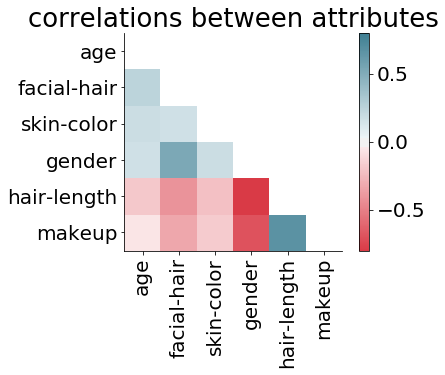

In [20]:
viz.corrplot(np.corrcoef(annotations_mat.transpose()))
plt.xticks(range(N), config.ATTRS, rotation='vertical')
plt.title('correlations between attributes')
plt.yticks(range(N), config.ATTRS)
plt.colorbar()
plt.show()

In [ ]:
N = len(config.ATTRS)
R, C = N, N


i = 0
plt.figure(figsize=(12, 12), dpi=150, facecolor='white')
ms = []
for r in tqdm(range(N)):
    attr = config.ATTRS[r]
    
    for c in range(N):
        attr_test = config.ATTRS[c]
        
        
        plt.subplot(R, C, i + 1)
        if c == 0:
            plt.ylabel(f'{attr}', fontsize=10)
        
        if r > c:
            plt.plot(annotations_mat[:, r], annotations_mat[:, c], '.', alpha=0.1, markeredgewidth=0)
        
        plt.yticks([])
        plt.xticks([])
        if r == N - 1:
            plt.xlabel(attr_test, fontsize=10)
        i += 1
plt.tight_layout() 